In [1]:
!pip install stop-words pymorphy2

In [2]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchmetrics

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel_Nazarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
max_words = 2000
max_len = 20
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [4]:
dataset_train  = 'train.csv'
dataset_test  = 'test.csv'
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=13)
df_train.head()

,id,label,tweet
24838,24839,0,#dreamcatcher bull up: you will dominate you...
18674,18675,0,@user when are you releasing the remix album.....
20179,20180,0,"vegas on sunday with my bff, her bf, and my bf"
1219,1220,0,happy monday everyone! lets make it a good wee...
19636,19637,0,mimando a mis compis del trabajo #cumpleaÃ±os ...


In [7]:
df_valid.head()

,id,label,tweet
9621,9622,0,not long now ... @user thank you for a beautif...
3388,3389,0,time to follow up the words and send somebody ...
12766,12767,0,if i posted a picture of a different #fingerpu...
24031,24032,0,@user reagan america was always at the forefro...
17357,17358,0,can't believe it's nearly been one week at my ...


In [8]:
sw = set(stopwords.words('english'))
print(sw)

{'what', 'out', 'my', "doesn't", 'me', 'with', "wasn't", 'haven', 'myself', 'needn', 'than', 'isn', 'because', 'here', "shouldn't", "isn't", 'can', 'same', 'how', 'shouldn', 'off', "hasn't", 'of', 'are', 'so', 'over', "you're", 'his', 'before', 'then', "mightn't", 'or', 'we', 'herself', 'the', 'it', 'once', 'while', 'her', 'couldn', 'when', 'should', 'your', 'as', 'hasn', 'but', 'didn', 'himself', 'from', 'all', 'up', 's', 'don', 'both', "shan't", 'above', 'most', 'hadn', 'weren', 'only', 'yourself', "won't", 'is', "don't", 'and', 'its', 'at', 'no', "should've", 'after', 'shan', 'about', 'yourselves', 'wouldn', 'to', "wouldn't", 'yours', 'own', 'mightn', 'this', 'during', 'why', 'few', "aren't", 'against', 'by', 'have', 'hers', 'whom', 'does', 'some', 'him', 'these', 'such', "you'd", 'on', 'mustn', 'she', 'will', 'a', 're', 'that', 'do', 'further', 'be', "it's", 'won', "she's", 'ourselves', 'if', 'too', 'now', 'o', 'each', 'just', 'into', 't', "that'll", 'where', 'they', 'theirs', 'm',

In [9]:
exclude = set(punctuation)
print(exclude)

{'{', ';', '\\', '?', '"', '&', '@', '.', '>', '!', '/', '~', '*', ']', ',', '(', '%', '[', '`', ':', '-', '=', '#', '+', '<', '|', "'", ')', '$', '^', '_', '}'}


In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [12]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 22373/22373 [00:01<00:00, 19563.29it/s]
C:\Users\PAVEL_~1\AppData\Local\Temp/ipykernel_5920/1444471780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
100%|██████████| 9589/9589 [00:00<00:00, 45813.67it/s]
C:\Users\PAVEL_~1\AppData\Local\Temp/ipykernel_5920/1444471780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
100%|██████████| 17197/17197 [

In [13]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:5]

['dreamcatcher', 'bull', 'dominate', 'bull', 'direct']

In [14]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [15]:
dist = FreqDist(tokens_filtered)
dist

FreqDist({'user': 12306, 'day': 1935, 'love': 1855, 'happy': 1154, 'amp': 1142, 'u': 1133, 'life': 869, 'time': 845, 'im': 808, 'like': 771, ...})

In [16]:
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999,
 ['user', 'day', 'love', 'happy', 'amp', 'u', 'life', 'time', 'im', 'like'])

In [17]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [18]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower()) 
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) 

    padding = [0] * (maxlen-len(result)) 
    return result[-maxlen:] + padding

In [19]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [20]:
torch.from_numpy(x_train[0])

tensor([ 41, 217,  41, 206, 151,  26,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0], dtype=torch.int32)

In [21]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() 
        self.target = torch.from_numpy(target).long() 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  
        y = self.target[index] 
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [22]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [23]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([234,  17,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
torch.Size([512]) tensor(0)


### GRU

In [24]:
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        gru_out, ht = self.gru(x) 

        if self.use_last:
            last_tensor = gru_out[:,-1,:] 
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1) 
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [25]:
model_gru = GRUFixedLen(max_words, 128, 128, use_last=False)
print(model_gru)
print("Parameters:", sum([param.nelement() for param in model_gru.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 454273


In [26]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [27]:
%%time

#обучение модели
model_gru.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_gru = []
valid_acc_history_gru = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_gru.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_gru.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_gru.append(train_acc.compute().item())
    train_acc.reset()
    

    # выводим статистику на тестовых данных

    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_gru(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)
    
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_gru.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/15]. Step [44/44]. Loss: 0.200. Acc: 0.911. Test loss: 0.035. Test acc: 0.940
Epoch [2/15]. Step [44/44]. Loss: 0.178. Acc: 0.939. Test loss: 0.460. Test acc: 0.948
Epoch [3/15]. Step [44/44]. Loss: 0.142. Acc: 0.949. Test loss: 0.046. Test acc: 0.953
Epoch [4/15]. Step [44/44]. Loss: 0.142. Acc: 0.954. Test loss: 0.022. Test acc: 0.953
Epoch [5/15]. Step [44/44]. Loss: 0.131. Acc: 0.957. Test loss: 0.004. Test acc: 0.954
Epoch [6/15]. Step [44/44]. Loss: 0.106. Acc: 0.961. Test loss: 0.029. Test acc: 0.955
Epoch [7/15]. Step [44/44]. Loss: 0.107. Acc: 0.964. Test loss: 0.019. Test acc: 0.951
Epoch [8/15]. Step [44/44]. Loss: 0.089. Acc: 0.967. Test loss: 0.008. Test acc: 0.952
Epoch [9/15]. Step [44/44]. Loss: 0.063. Acc: 0.969. Test loss: 0.030. Test acc: 0.952
Epoch [10/15]. Step [44/44]. Loss: 0.089. Acc: 0.971. Test loss: 0.472. Test acc: 0.953
Epoch [11/15]. Step [44/44]. Loss: 0.057. Acc: 0.972. Test loss: 0.196. Test acc: 0.953
Epoch [12/15]. Step [44/44]. Loss: 0.105.

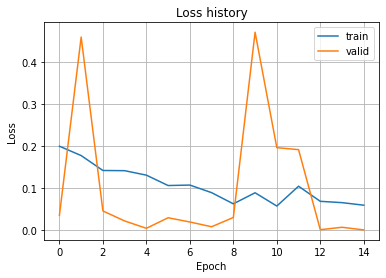

In [28]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

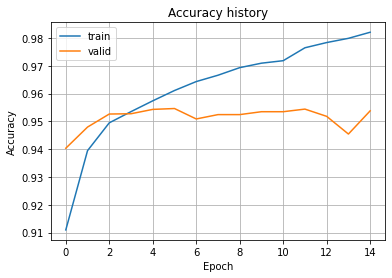

In [29]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_gru, label='train')
plt.plot(valid_acc_history_gru, label='valid')
plt.legend()

### LSTM

In [30]:
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 

        if self.use_last:
            last_tensor = lstm_out[:,-1,:] 
        else: 
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [31]:
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(model_lstm)
print("Parameters:", sum([param.nelement() for param in model_lstm.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 520321


In [32]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [33]:
%%time

#обучение модели
model_lstm.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_lstm = []
valid_acc_history_lstm = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_lstm.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_lstm.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(valid_loader):
        test_labels = data[1]
        test_outputs = model_lstm(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)

    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_lstm.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/15]. Step [44/44]. Loss: 0.211. Acc: 0.908. Test loss: 0.075. Test acc: 0.937
Epoch [2/15]. Step [44/44]. Loss: 0.236. Acc: 0.936. Test loss: 0.089. Test acc: 0.945
Epoch [3/15]. Step [44/44]. Loss: 0.160. Acc: 0.947. Test loss: 0.359. Test acc: 0.950
Epoch [4/15]. Step [44/44]. Loss: 0.125. Acc: 0.953. Test loss: 0.020. Test acc: 0.954
Epoch [5/15]. Step [44/44]. Loss: 0.133. Acc: 0.958. Test loss: 0.017. Test acc: 0.954
Epoch [6/15]. Step [44/44]. Loss: 0.127. Acc: 0.962. Test loss: 0.023. Test acc: 0.953
Epoch [7/15]. Step [44/44]. Loss: 0.065. Acc: 0.965. Test loss: 0.471. Test acc: 0.955
Epoch [8/15]. Step [44/44]. Loss: 0.084. Acc: 0.967. Test loss: 0.049. Test acc: 0.955
Epoch [9/15]. Step [44/44]. Loss: 0.114. Acc: 0.972. Test loss: 0.007. Test acc: 0.950
Epoch [10/15]. Step [44/44]. Loss: 0.067. Acc: 0.974. Test loss: 0.520. Test acc: 0.953
Epoch [11/15]. Step [44/44]. Loss: 0.091. Acc: 0.975. Test loss: 0.688. Test acc: 0.955
Epoch [12/15]. Step [44/44]. Loss: 0.073.

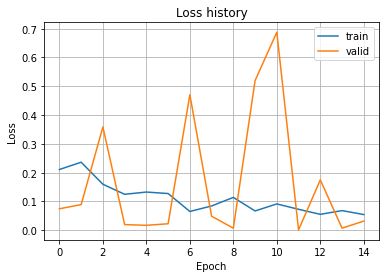

In [34]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

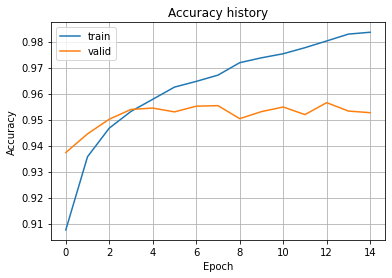

In [35]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_lstm, label='train')
plt.plot(valid_acc_history_lstm, label='valid')
plt.legend()

In [36]:
metrics_result = pd.DataFrame([{'Acc_train': train_acc_history_lstm[-1], 
                                'Acc_test': valid_acc_history_lstm[-1]},
                               {'Acc_train':  train_acc_history_gru[-1],
                                'Acc_test': valid_acc_history_gru[-1]}],
                              index =['LSTM', 'GRU'], 
                              columns =['Acc_train', 'Acc_test'])

metrics_result.sort_values(by='Acc_test', ascending=False)

,Acc_train,Acc_test
GRU,0.982077,0.953801
LSTM,0.983596,0.952654


LSTM обучается дольше, при этом в моем случае - метрика на тест у GRU оказалась выше. Изменение количества эпох при разных испытаних давал странный ответ (при этом не было монотонного улучшения). Увеличение hidden_dim, embedding_dim, max_words могут способствовать увеличению метрики на валидации, однако в некоторых случаях не всегда так было у меня